# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'FCN' # 'CNN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


31364it [00:32, 975.09it/s] 


Better to keep validation and testing set in RAM

In [8]:
val_dataset = Shrec17Dataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

5133it [00:05, 987.97it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


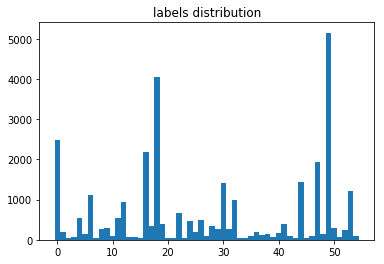

In [9]:
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [10]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
#ids = train_dataset.retrieve_ids()
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 004047


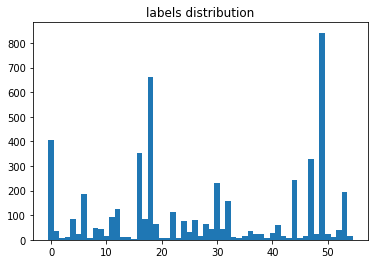

In [11]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [28]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

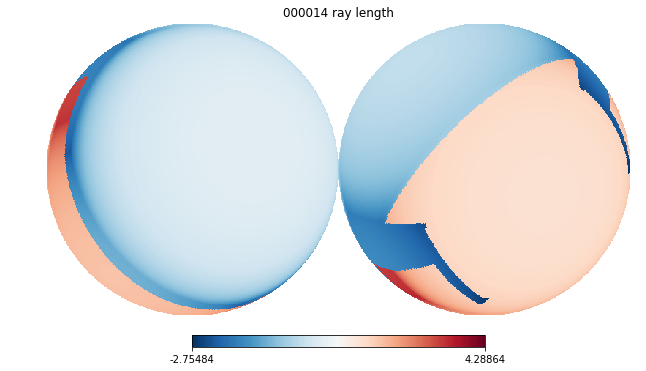

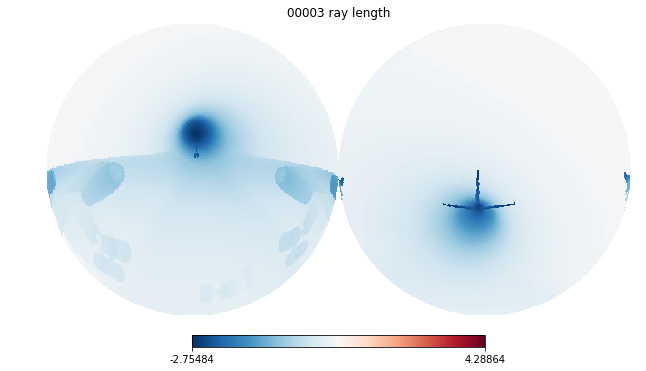

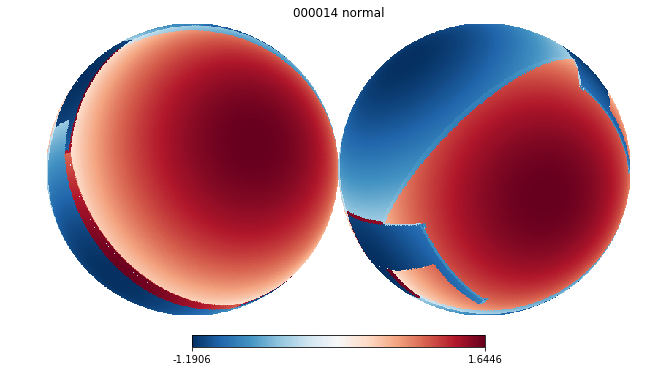

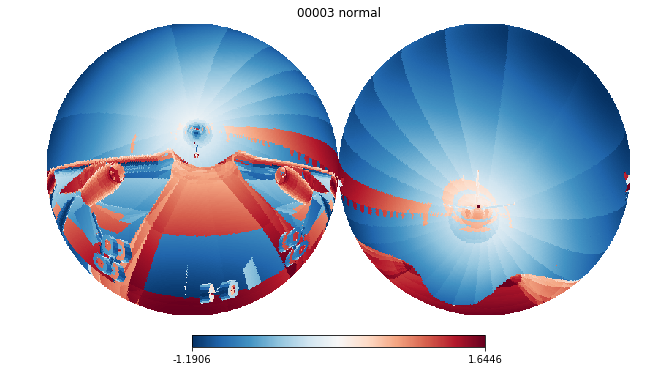

In [29]:
hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003, rot=(30,330,40), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
hp.orthview(im0003_norm, rot=(30,330,40), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [12]:
#training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [13]:
EXP_NAME = 'shrec17_best_5K_6layers_reg_{}sides{}'.format(Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
#EXP_NAME = 'plop'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

To find best parameters, loop over:
- K: 2, 3, 5
- depth: 3, 5, 8 gconv
- Nside: 32, 64, 128

In [14]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 38,540,083,200
Learning rate will start at 1.0e-03 and finish at 1.0e-03.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 32 / 4 = 98304
    weights: F_0 * F_1 * K_1 = 6 * 32 * 5 = 960
    biases: F_1 = 32
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 64 / 4 = 49152
    weights: F_1 * F_2 * K_2 = 32 * 64 * 5 = 10240
    biases: F_2 = 64
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 64 * 64 * 5 = 20480
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
 

In [15]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 32 / 4 = 98304
    weights: F_0 * F_1 * K_1 = 6 * 32 * 5 = 960
    biases: F_1 = 32
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 32 * 32 * 5 = 5120
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 64 / 4 = 3072
    weights: F_3 * F_4 * K_4 = 64 * 64 * 5 = 20480
    biases: F_4 = 64
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 48 * 55 / 1 = 2640
    weights: F_4 * F_5 * K_5 = 64 * 55 * 5 = 17600
    batch normalization
  Statistical layer: mean
    representation: 1 * 55 = 55
step 490 / 19602 (epoch 0.50 / 20):
  learning_rate = 1.78e-

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.88 (45 / 5133), f1 (weighted): 1.03, loss: 4.09e+00
  CPU time: 62s, wall time: 78s, perf_time_load: 0.12s, perf_time: 0.11s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 3.64e+00
  validation accuracy: 17.28 (887 / 5133), f1 (weighted): 12.98, loss: 3.60e+00
  CPU time: 119s, wall time: 150s, perf_time_load: 0.13s, perf_time: 0.12s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 2.98e+00
  validation accuracy: 34.99 (1796 / 5133), f1 (weighted): 25.00, loss: 3.02e+00
  CPU time: 171s, wall time: 219s, perf_time_load: 0.15s, perf_time: 0.14s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 2.37e+00
  validation accuracy: 43.07 (2211 / 5133), f1 (weighted): 31.50, loss: 2.59e+00
  CPU time: 228s, wall time: 291s, perf_time_load: 0.12s, perf_time: 0.12s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 2.14e+00
  validation accuracy: 4

step 17150 / 19602 (epoch 17.50 / 20):
  learning_rate = 5.60e+02, training loss = 6.17e+00
  validation accuracy: 7.89 (405 / 5133), f1 (weighted): 1.15, loss: 6.75e+00
  CPU time: 1725s, wall time: 2399s, perf_time_load: 0.13s, perf_time: 0.11s
step 17640 / 19602 (epoch 18.00 / 20):
  learning_rate = 9.96e+02, training loss = 4.01e+00
  validation accuracy: 7.89 (405 / 5133), f1 (weighted): 1.15, loss: 4.02e+00
  CPU time: 1771s, wall time: 2466s, perf_time_load: 0.12s, perf_time: 0.11s
step 18130 / 19602 (epoch 18.50 / 20):
  learning_rate = 1.77e+03, training loss = 5.48e+00
  validation accuracy: 7.89 (405 / 5133), f1 (weighted): 1.15, loss: 4.33e+00
  CPU time: 1816s, wall time: 2532s, perf_time_load: 0.15s, perf_time: 0.14s
step 18620 / 19602 (epoch 19.00 / 20):
  learning_rate = 3.15e+03, training loss = 7.76e+01
  validation accuracy: 7.89 (405 / 5133), f1 (weighted): 1.15, loss: 7.28e+01
  CPU time: 1864s, wall time: 2600s, perf_time_load: 0.13s, perf_time: 0.12s
step 19110 /

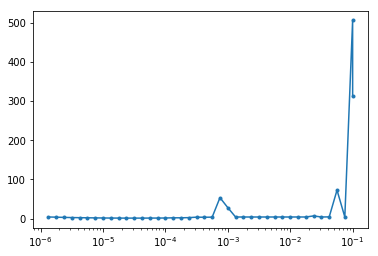

In [22]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(training, validation)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

In [29]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [16]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
conv6/weights:0
the number of parameters in the model is: 190,176


In [17]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 1.00e-03, training loss = 1.15e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 71.24 (3657 / 5133), f1 (weighted): 67.66, loss: 1.30e+00
  CPU time: 60s, wall time: 86s, perf_time_load: 0.14s, perf_time: 0.13s
step 980 / 98012 (epoch 1.00 / 100):
  learning_rate = 1.00e-03, training loss = 1.24e+00
  validation accuracy: 72.76 (3735 / 5133), f1 (weighted): 70.81, loss: 1.25e+00
  CPU time: 111s, wall time: 164s, perf_time_load: 0.14s, perf_time: 0.13s
step 1470 / 98012 (epoch 1.50 / 100):
  learning_rate = 1.00e-03, training loss = 9.83e-01
  validation accuracy: 74.89 (3844 / 5133), f1 (weighted): 72.71, loss: 1.15e+00
  CPU time: 162s, wall time: 240s, perf_time_load: 0.14s, perf_time: 0.13s
step 1960 / 98012 (epoch 2.00 / 100):
  learning_rate = 1.00e-03, training loss = 9.21e-01
  validation accuracy: 76.00 (3901 / 5133), f1 (weighted): 73.95, loss: 1.13e+00
  CPU time: 212s, wall time: 316s, perf_time_load: 0.13s, perf_time: 0.12s
step 2450 / 98012 (epoch 2.50 / 100):
  learning_rate = 1.00e-03, training loss = 9.79e-01
  validation ac

  validation accuracy: 79.97 (4105 / 5133), f1 (weighted): 78.76, loss: 1.09e+00
  CPU time: 1595s, wall time: 2557s, perf_time_load: 0.13s, perf_time: 0.13s
step 17150 / 98012 (epoch 17.50 / 100):
  learning_rate = 1.00e-03, training loss = 5.61e-01
  validation accuracy: 79.66 (4089 / 5133), f1 (weighted): 78.99, loss: 1.10e+00
  CPU time: 1648s, wall time: 2636s, perf_time_load: 0.14s, perf_time: 0.13s
step 17640 / 98012 (epoch 18.00 / 100):
  learning_rate = 1.00e-03, training loss = 6.01e-01
  validation accuracy: 80.03 (4108 / 5133), f1 (weighted): 78.71, loss: 1.09e+00
  CPU time: 1698s, wall time: 2713s, perf_time_load: 0.13s, perf_time: 0.13s
step 18130 / 98012 (epoch 18.50 / 100):
  learning_rate = 1.00e-03, training loss = 5.29e-01
  validation accuracy: 79.27 (4069 / 5133), f1 (weighted): 78.57, loss: 1.10e+00
  CPU time: 1750s, wall time: 2792s, perf_time_load: 0.14s, perf_time: 0.13s
step 18620 / 98012 (epoch 19.00 / 100):
  learning_rate = 1.00e-03, training loss = 6.34e

  validation accuracy: 80.11 (4112 / 5133), f1 (weighted): 79.48, loss: 1.16e+00
  CPU time: 3234s, wall time: 5063s, perf_time_load: 0.14s, perf_time: 0.13s
step 33320 / 98012 (epoch 34.00 / 100):
  learning_rate = 1.00e-03, training loss = 4.87e-01
  validation accuracy: 80.64 (4139 / 5133), f1 (weighted): 79.84, loss: 1.12e+00
  CPU time: 3282s, wall time: 5138s, perf_time_load: 0.14s, perf_time: 0.13s
step 33810 / 98012 (epoch 34.50 / 100):
  learning_rate = 1.00e-03, training loss = 6.86e-01
  validation accuracy: 79.74 (4093 / 5133), f1 (weighted): 78.84, loss: 1.16e+00
  CPU time: 3330s, wall time: 5213s, perf_time_load: 0.14s, perf_time: 0.13s
step 34300 / 98012 (epoch 35.00 / 100):
  learning_rate = 1.00e-03, training loss = 4.35e-01
  validation accuracy: 80.79 (4147 / 5133), f1 (weighted): 79.78, loss: 1.14e+00
  CPU time: 3377s, wall time: 5288s, perf_time_load: 0.13s, perf_time: 0.13s
step 34790 / 98012 (epoch 35.50 / 100):
  learning_rate = 1.00e-03, training loss = 6.33e

  validation accuracy: 80.38 (4126 / 5133), f1 (weighted): 79.28, loss: 1.18e+00
  CPU time: 4756s, wall time: 7502s, perf_time_load: 0.14s, perf_time: 0.13s
step 49490 / 98012 (epoch 50.49 / 100):
  learning_rate = 1.00e-03, training loss = 5.27e-01
  validation accuracy: 80.69 (4142 / 5133), f1 (weighted): 79.96, loss: 1.19e+00
  CPU time: 4805s, wall time: 7577s, perf_time_load: 0.14s, perf_time: 0.13s
step 49980 / 98012 (epoch 50.99 / 100):
  learning_rate = 1.00e-03, training loss = 4.57e-01
  validation accuracy: 79.41 (4076 / 5133), f1 (weighted): 78.72, loss: 1.19e+00
  CPU time: 4853s, wall time: 7651s, perf_time_load: 0.15s, perf_time: 0.15s
step 50470 / 98012 (epoch 51.49 / 100):
  learning_rate = 1.00e-03, training loss = 5.79e-01
  validation accuracy: 80.36 (4125 / 5133), f1 (weighted): 79.70, loss: 1.18e+00
  CPU time: 4900s, wall time: 7726s, perf_time_load: 0.13s, perf_time: 0.13s
step 50960 / 98012 (epoch 51.99 / 100):
  learning_rate = 1.00e-03, training loss = 4.85e

  validation accuracy: 78.84 (4047 / 5133), f1 (weighted): 77.90, loss: 1.30e+00
  CPU time: 6340s, wall time: 9960s, perf_time_load: 0.14s, perf_time: 0.13s
step 65660 / 98012 (epoch 66.99 / 100):
  learning_rate = 1.00e-03, training loss = 6.77e-01
  validation accuracy: 78.88 (4049 / 5133), f1 (weighted): 77.88, loss: 1.25e+00
  CPU time: 6389s, wall time: 10035s, perf_time_load: 0.13s, perf_time: 0.12s
step 66150 / 98012 (epoch 67.49 / 100):
  learning_rate = 1.00e-03, training loss = 9.31e-01
  validation accuracy: 78.94 (4052 / 5133), f1 (weighted): 77.97, loss: 1.30e+00
  CPU time: 6439s, wall time: 10111s, perf_time_load: 0.14s, perf_time: 0.12s
step 66640 / 98012 (epoch 67.99 / 100):
  learning_rate = 1.00e-03, training loss = 4.85e-01
  validation accuracy: 79.72 (4092 / 5133), f1 (weighted): 79.04, loss: 1.21e+00
  CPU time: 6488s, wall time: 10186s, perf_time_load: 0.13s, perf_time: 0.13s
step 67130 / 98012 (epoch 68.49 / 100):
  learning_rate = 1.00e-03, training loss = 8.

step 81340 / 98012 (epoch 82.99 / 100):
  learning_rate = 1.00e-03, training loss = 4.89e-01
  validation accuracy: 79.37 (4074 / 5133), f1 (weighted): 78.48, loss: 1.25e+00
  CPU time: 7926s, wall time: 12444s, perf_time_load: 0.13s, perf_time: 0.12s
step 81830 / 98012 (epoch 83.49 / 100):
  learning_rate = 1.00e-03, training loss = 5.35e-01
  validation accuracy: 80.15 (4114 / 5133), f1 (weighted): 79.26, loss: 1.23e+00
  CPU time: 7974s, wall time: 12519s, perf_time_load: 0.13s, perf_time: 0.13s
step 82320 / 98012 (epoch 83.99 / 100):
  learning_rate = 1.00e-03, training loss = 5.20e-01
  validation accuracy: 79.41 (4076 / 5133), f1 (weighted): 78.79, loss: 1.24e+00
  CPU time: 8022s, wall time: 12594s, perf_time_load: 0.14s, perf_time: 0.13s
step 82810 / 98012 (epoch 84.49 / 100):
  learning_rate = 1.00e-03, training loss = 5.26e-01
  validation accuracy: 79.60 (4086 / 5133), f1 (weighted): 78.84, loss: 1.25e+00
  CPU time: 8066s, wall time: 12667s, perf_time_load: 0.13s, perf_time

step 97510 / 98012 (epoch 99.49 / 100):
  learning_rate = 1.00e-03, training loss = 4.98e-01
  validation accuracy: 79.33 (4072 / 5133), f1 (weighted): 78.58, loss: 1.26e+00
  CPU time: 9530s, wall time: 14916s, perf_time_load: 0.13s, perf_time: 0.13s
step 98000 / 98012 (epoch 99.99 / 100):
  learning_rate = 1.00e-03, training loss = 4.33e-01
  validation accuracy: 78.88 (4049 / 5133), f1 (weighted): 78.06, loss: 1.30e+00
  CPU time: 9580s, wall time: 14991s, perf_time_load: 0.16s, perf_time: 0.15s
step 98012 / 98012 (epoch 100.00 / 100):
  learning_rate = 1.00e-03, training loss = 6.16e-01
  validation accuracy: 79.52 (4082 / 5133), f1 (weighted): 78.65, loss: 1.25e+00
  CPU time: 9591s, wall time: 15002s, perf_time_load: 0.14s, perf_time: 0.13s
validation accuracy: best = 81.39, mean = 79.09
time per batch: mean = 0.14, var = 0.10%


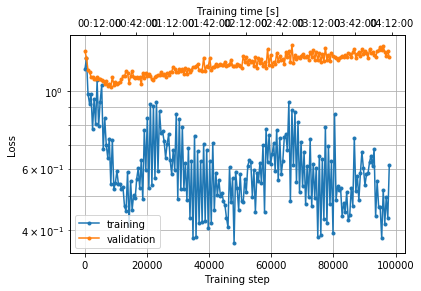

In [19]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [20]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN/model-98012


('accuracy: 91.18 (28598 / 31364), f1 (weighted): 90.99, loss: 6.12e-01\nCPU time: 63s, wall time: 56s',
 91.18097181481953,
 90.98559870265348,
 0.6119592816774038)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [21]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN/model-98012


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 79.52 (4082 / 5133), f1 (weighted): 78.65, loss: 1.25e+00\nCPU time: 14s, wall time: 12s',
 79.5246444574323,
 78.65434354256688,
 1.2483585015064138)

In [22]:
probabilities = model.probs(x_val, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = repeat.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN/model-98012


In [ ]:
#predictions = predictions.astype(np.int)

In [23]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_deep/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_deep/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [24]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:20, 495.37it/s]


info non-existent


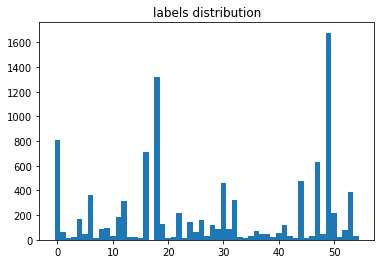

In [25]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [26]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN/model-98012


('accuracy: 74.76 (7674 / 10265), f1 (weighted): 74.48, loss: 1.40e+00\nCPU time: 20s, wall time: 19s',
 74.7588894301023,
 74.4826085058601,
 1.4017307652186837)

In [ ]:
#predictions = model.predict(x_test)

In [27]:
probabilities = model.probs(x_test, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = repeat.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_6layers_reg_32sides_FCN/model-98012


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [28]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_deep/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_deep/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [29]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

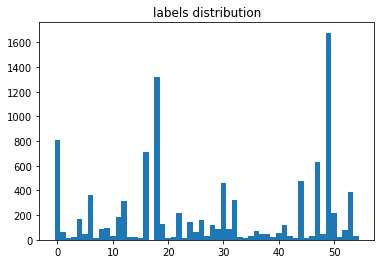

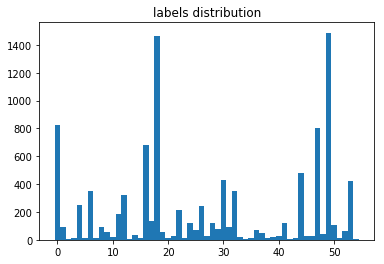

In [30]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)